In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.metrics import log_loss
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
def upsample(test, monsterframe=False):
    '''
    input: test (pandas.dataframe)
    output: pandas.dataframe
    
    input dataframe MUST have the columns dem_win_prev and dem_win
    function will ensure that there are an equal number of flips and no flips in the dataset via bootstrap
    '''
    
    #check if party flip as per usual
    test['party_flip'] = (test.dem_win_prev != test.dem_win)*1
    #drop 2018 rows as we want to test on these, don't mess with them
    test = test[test['year'] != 2018]
    #count number of flips and no flips
    print(np.sum((test['party_flip']==1)), np.sum((test['party_flip']==0)))
    #we want to match these counts, so we need target number of bootstrapped samples
    target = (np.sum((test['party_flip']==0))) - (np.sum((test['party_flip']==1)))
    #collect target bootstrap samples where we see a flip
    samples = test[test['party_flip'] == 1].sample(n=target, replace=True)
    #add them back to the dataframe
    test = pd.concat([test, samples])
    print(np.sum((test['party_flip']==1)), np.sum((test['party_flip']==0)))
    print(len(set(test[test['party_flip'] == 1].index)))
    test = test.drop('party_flip', axis=1)
    
    if monsterframe:
        target = 5*(len(test))
        samples = test.sample(n=target, replace=True)
        test = pd.concat([test, samples])
    print(len(test))
    
    
    
    return test

#full_dataset = boostrap(full_dataset)

## Code without demographics

* district
* state
* year
* party
* candidatevotes
* totalvotes
* candidate
* national_poll
* national_poll_prev
* national_poll_delta_subtract
* national_poll_delta_divide
* previous_party
* dem_win_margin_prev
* rep_win_margin_prev
* margin_signed_minus_prev
* margin_signed_divide_prev
* margin_unsigned_minus_prev
* margin_unsigned_divide_prev
* dem_win_prev
* rep_win_prev
* dem_win
* rep_win

### columns in demographics


['district', 'state', 'year', 'party', 'candidatevotes', 'totalvotes',
       'candidate', 'national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'previous_party', 'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev', 'dem_win', 'rep_win', 'female_pct',
       'age18_24_pct', 'age25_34_pct', 'median_age', 'unmarried_partner_pct',
       'male_living_alone_pct', 'bachelors_deg_or_higher_pct',
       'past_year_births_to_unmarried_women_pct', 'civilian_veteran_pct',
       'live_same_house_past_year_pct',
       'foreign_born_proportion_from_LatinAmerica',
       'speak_other_language_at_home_pct', 'labor_force_unemployed_pct',
       'public_transit_commuter_pct', 'no_health_insurance_pct',
       'poverty_rate_pct', 'median_housing_value', 'median_household_income',
       'food_stamp_benefits_pct', 'foreign_to_native_born_ratio']

# Functions

In [6]:
# format data items for input into the model

def format_model_input(filename, x_cols, y_col, state_hot_encoder=False, upsample=False):
    
    # load full dataset 
    full_dataset = pickle.load(open(filename, 'rb'))
    
    # train data is everything except 2018
    if upsample:
        pre_2018_dataset = full_dataset.loc[full_dataset['year']!=2018]
        pre_2018_dataset = upsample(pre_2018_dataset, monsterframe=False)
    else:
        pre_2018_dataset = full_dataset.loc[full_dataset['year']!=2018]

    X_train = pre_2018_dataset[cols_to_use]
    y_train = pre_2018_dataset[y_col]
    flip_train = np.abs(pre_2018_dataset['dem_win']-pre_2018_dataset['dem_win_prev'])
    
    # test data is 2018
    the_2018_dataset = full_dataset.loc[full_dataset['year']==2018]
    X_test = the_2018_dataset[cols_to_use]
    y_test = the_2018_dataset[y_col]
    flip_test = np.abs(the_2018_dataset['dem_win']-the_2018_dataset['dem_win_prev'])
    
    if state_hot_encoder:
        #add one hot encoder for states (with or without dropping first)
        X_train.loc[:,'state'] = pre_2018_dataset['state']
        X_train = pd.get_dummies(X_train,prefix='state',columns=['state'], drop_first=True)
        X_test.loc[:,'state'] = the_2018_dataset['state']
        X_test = pd.get_dummies(X_test,prefix='state',columns=['state'], drop_first=True)
        
        # Make sure train and test have all the same states
            # the problem is that PA is no longer in the test set...
        states_missing_in_test = np.array([x for x in X_train.columns.values if x not in X_test.columns.values])
        if states_missing_in_test.size!=0:
            for state_missing in states_missing_in_test:
                X_test[state_missing] = 0
    
    return X_train,y_train, X_test,y_test, flip_train,flip_test

In [7]:
def plot_metrics(model_dict, X_train_input, y_train_input, X_test_input, y_test_input, flip_train, flip_test, prob=False):
    
    df_for_plotting = pd.DataFrame()
    for model_name, model in model_dict.items():
        dict_for_plotting = {}
        # copy arrays so you don't accidentally change them 
        X_train = X_train_input.copy()
        y_train = y_train_input.copy()
        X_test = X_test_input.copy()
        y_test = y_test_input.copy()
        
        # get the flip and noflip data
        #flip_mask_train = np.array(flip_train)==1
        flip_mask_test = np.array(flip_test)==1

        # calculate metrics
        if prob==True:    
            # predict_proba test and train data
            y_prob_test = model.predict_proba(X_test)
            y_prob_train = model.predict_proba(X_train)
            
            train_score = log_loss(y_train, y_prob_train)
            test_score = log_loss(y_test, y_prob_test)
            percent_noflip_correct = log_loss(y_test[~flip_mask_test], y_prob_test[~flip_mask_test])
            percent_flip_correct = log_loss(y_test[flip_mask_test],y_prob_test[flip_mask_test])
            
            
            # train score
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'train_logloss'
            dict_for_plotting['metric'] = train_score
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # test score
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'test_logloss'
            dict_for_plotting['metric'] = test_score
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # percent noflip
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'noflip_logloss'
            dict_for_plotting['metric'] = percent_noflip_correct
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # percent flip
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'flip_logloss'
            dict_for_plotting['metric'] = percent_flip_correct
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)
            plt.ylim(0.,35.)
            
        else:
            # predict test and train data
            y_pred_test = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            
            y_pred_train = y_pred_train.round()
            y_pred_test = y_pred_test.round()
            train_score = accuracy_score(y_train, y_pred_train)
            test_score = accuracy_score(y_test, y_pred_test)
            percent_noflip_correct = accuracy_score(y_test[~flip_mask_test], y_pred_test[~flip_mask_test])
            percent_flip_correct = accuracy_score(y_test[flip_mask_test],y_pred_test[flip_mask_test])
        
            # train score
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'train_acc'
            dict_for_plotting['metric'] = train_score
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # test score
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'test_acc'
            dict_for_plotting['metric'] = test_score
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # percent noflip
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'noflip_acc'
            dict_for_plotting['metric'] = percent_noflip_correct
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

            # percent flip
            dict_for_plotting['model_name'] = model_name
            dict_for_plotting['metric_name'] = 'flip_acc'
            dict_for_plotting['metric'] = percent_flip_correct
            df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)
        
    with sns.color_palette("Paired"):
        sns.barplot(x='model_name', y='metric', hue='metric_name', data=df_for_plotting)
    plt.show()

In [8]:
# plot flips predicted by a model

def plot_flips(X_test_input, y_test_input, y_pred_test_input, flip_train, 
               flip_test, model_name):
    
    # copy arrays so you don't accidentally change them 
    X_test = X_test_input.copy()
    y_test = y_test_input.copy()
    y_pred_test = y_pred_test_input.copy()
    
    # add flip data to the array
    X_test['party_flip'] = flip_test
    
    #looking at the missclassifications with logisticRegressionCV
    miss_class_df = X_test[y_test != y_pred_test]
    good_class_df = X_test[y_test == y_pred_test]

    #plot the flips and non flips for each data
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].set_title(model_name+' Proportion of party flips on wellclassified test data')
    ax[1].set_title(model_name+' Proportion of party flips missclassified test data')

    if not good_class_df.empty:
        good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
        for name, group in (good_class_df.groupby('party_flip')['party_flip']):
            ax[0].text(int(name)+.25, group.count() + .25, \
            '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

    if not miss_class_df.empty:
        miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])
        for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
            ax[1].text(int(name)+.15, group.count() + .25, \
            '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')
            
    normnoflip = len(X_test[X_test['party_flip'] == 0])
    normflip = len(X_test[X_test['party_flip'] == 1])
    print('predicted correctly. does not flip.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 0])/normnoflip))
    print('predicted wrongly. does not flip.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 0])/normnoflip))
    
    print('predicted correctly. does flips.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 1])/normflip))
    print('predicted wrongly. does flips.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 1])/normflip))
        
    plt.show()

In [9]:
# print out R2, accuracy, and plot # flipped seats correctly predicted for a given model

def report_model_stats(filename, x_cols, y_col, model_dict, state_hot_encoder=False, upsample=False):
    
    # read in the desired data
    X_train,y_train, X_test,y_test, flip_train,flip_test = \
        format_model_input(filename, cols_to_use, y_col, state_hot_encoder)
        
    fitted_model_dict = {}
    
    for model_name, model in model_dict.items():
        model_copy = clone(model) # deep copy model to prevent fitting it twice
        print(model_name)

        fitted_model = model_copy.fit(X_train,y_train)
        y_pred_test = fitted_model.predict(X_test)

#         print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test.round()))
#         print("\n{} R2: ".format(model_name), fitted_model.score(X_train,y_train))
#         print("{} Test Accuracy".format(model_name), accuracy_score(y_test,y_pred_test.round()))
#         plot_flips(X_test, y_test, y_pred_test.round(), flip_train, flip_test, model_name)
        
        fitted_model_dict[model_name] = fitted_model
        
        
        try:
            coef = fitted_model.coef_.squeeze()
            print(len(X_test.columns), len(coef))
            print('intercept = {}'.format(fitted_model.intercept_))
            print([i for i in zip(X_test.columns,coef)])
        except AttributeError:
            print('doesnt have any coefficients')
    
    plot_metrics(fitted_model_dict, X_train, y_train, X_test, y_test, flip_train, flip_test, prob=False)
    plot_metrics(fitted_model_dict, X_train, y_train, X_test, y_test, flip_train, flip_test, prob=True)
    
    return fitted_model_dict

## Try out different models and columns

In [10]:
# specify your models here:
model_dict = {
    'LDA'           : LDA(),
    'QDA'           : QDA(),
    'LogReg'        : LogisticRegression(n_jobs=4),
    'kNN'           : KNeighborsClassifier(n_neighbors=1,n_jobs=4),
    'Random Forest' : RandomForestClassifier(n_jobs=4,random_state=209),
    'AdaBoost'      : AdaBoostClassifier(DecisionTreeClassifier(max_depth=10)),
}

y_col = ['dem_win']
upsample=False

### Selected columns in the full dataset, no demographics

LDA
51 51
intercept = [-3.05313844]
[('national_poll', 0.11698179182225263), ('margin_signed_minus_prev', 8.763378532955986), ('state_AL', 1.652354949752635), ('state_AR', 0.6361203118168897), ('state_AZ', 2.3900692666182266), ('state_CA', 2.8933849340210744), ('state_CO', 2.3384522274429114), ('state_CT', 5.054805623465385), ('state_DE', 4.042219974410054), ('state_FL', 1.620840495105497), ('state_GA', 2.5018625940726107), ('state_HI', 4.893068564094925), ('state_IA', 2.3430447911934245), ('state_ID', 0.49248873481041144), ('state_IL', 1.9696489820375078), ('state_IN', 1.6228161505519518), ('state_KS', 1.3622435576124707), ('state_KY', 1.7406143470098505), ('state_LA', 1.711263031607234), ('state_MA', 4.1190730297335145), ('state_MD', 3.6567367586507924), ('state_ME', 4.585689476311983), ('state_MI', 1.0959447311812367), ('state_MN', 2.698642572805327), ('state_MO', 1.7041254669414734), ('state_MS', 2.1389206991564667), ('state_MT', -0.55459419686268), ('state_NC', 1.826423845403741),

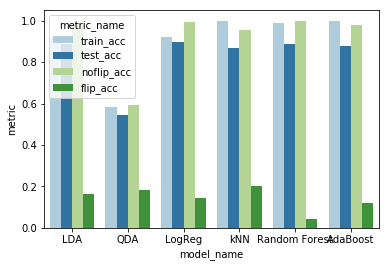

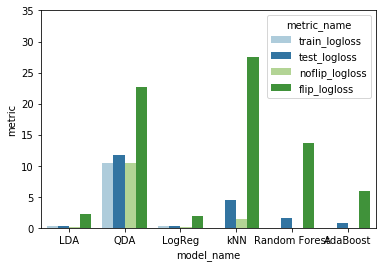

In [11]:
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev']
state_hot_encoder = True

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

### Selected columns in the full dataset, no demographics, dropping redistricted states

LDA
51 51
intercept = [-3.30279959]
[('national_poll', 0.13685292828512854), ('margin_signed_minus_prev', 10.100915191890495), ('state_AL', 1.5829471016368128), ('state_AR', 0.8653163913771346), ('state_AZ', 2.3789680976050454), ('state_CA', 2.851760208698378), ('state_CO', 2.3368034409492173), ('state_CT', 5.428657040279262), ('state_DE', 4.402625283027513), ('state_FL', 1.1633481604877605), ('state_GA', 2.4138983676473402), ('state_HI', 5.190924279659384), ('state_IA', 2.347982915570591), ('state_ID', 0.5355874756307804), ('state_IL', 1.738476631545709), ('state_IN', 1.7906610626457384), ('state_KS', 1.7247995341495643), ('state_KY', 2.0658032486326485), ('state_LA', 1.8528323530743058), ('state_MA', 4.057291763559088), ('state_MD', 3.748428938669935), ('state_ME', 4.900768174424802), ('state_MI', 0.8980844880552932), ('state_MN', 2.8982992143915762), ('state_MO', 1.8694679358307842), ('state_MS', 2.135789105334328), ('state_MT', -0.639240782234566), ('state_NC', 2.0923688428277374),

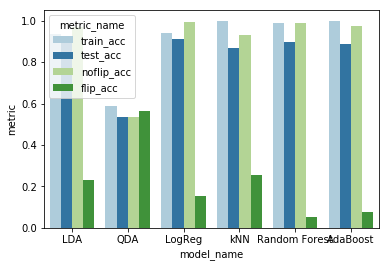

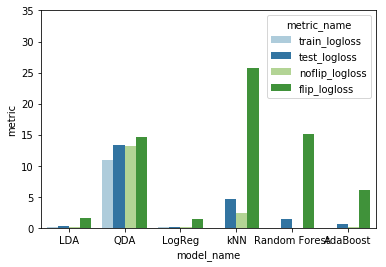

In [12]:
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev']
state_hot_encoder = True

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

### Selected columns in the full dataset, no demographics, imputing redistricted states

In [13]:
# Not Implemented

### Selected columns in dataset since 2010, with demographics, nothing dropped

LDA
60 60
intercept = [-44.27991625]
[('national_poll', 0.42277425580607403), ('margin_signed_minus_prev', 1.5572412935377047), ('dem_win_prev', 8.941689297847256), ('female_pct', 0.6306672431846874), ('civilian_veteran_pct', -0.2495961540435208), ('foreign_to_native_born_ratio', 1.570841238420161), ('labor_force_unemployed_pct', 0.422286756843455), ('age18_24_pct', 0.21891369828549495), ('bachelors_deg_or_higher_pct', 0.013759874028573748), ('age25_34_pct', 0.2975430014696733), ('median_household_income', -3.1008767869877316e-06), ('state_AL', -1.7241045853912769), ('state_AR', -2.809348541749608), ('state_AZ', 0.354709396167793), ('state_CA', 0.3233193260804623), ('state_CO', 0.253621461891669), ('state_CT', 3.205751067707186), ('state_DE', 6.440965139830364), ('state_FL', 0.1203002562690765), ('state_GA', -1.0872815298446983), ('state_HI', 4.999293069067463), ('state_IA', 0.528639580286474), ('state_ID', -1.9508172011645097), ('state_IL', -0.2273809175030713), ('state_IN', -1.207057

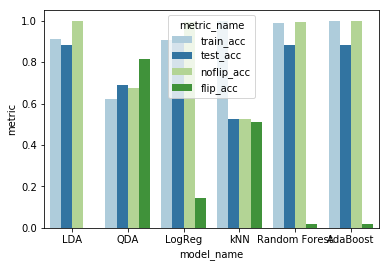

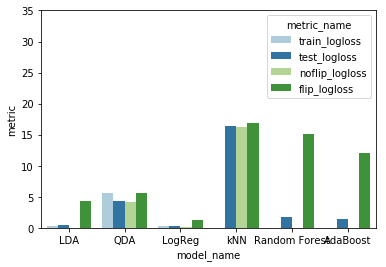

In [17]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev', 'dem_win_prev', 
               'female_pct', 'civilian_veteran_pct', 'foreign_to_native_born_ratio', 'labor_force_unemployed_pct',
               'age18_24_pct', 'bachelors_deg_or_higher_pct', 'age25_34_pct', 'median_household_income']
state_hot_encoder = True

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

### Selected columns in dataset since 2010, with demographics, dropping redistricted states

LDA
60 60
intercept = [-44.27991625]
[('national_poll', 0.42277425580607403), ('margin_signed_minus_prev', 1.5572412935377047), ('dem_win_prev', 8.941689297847256), ('female_pct', 0.6306672431846874), ('civilian_veteran_pct', -0.2495961540435208), ('foreign_to_native_born_ratio', 1.570841238420161), ('labor_force_unemployed_pct', 0.422286756843455), ('age18_24_pct', 0.21891369828549495), ('bachelors_deg_or_higher_pct', 0.013759874028573748), ('age25_34_pct', 0.2975430014696733), ('median_household_income', -3.1008767869877316e-06), ('state_AL', -1.7241045853912769), ('state_AR', -2.809348541749608), ('state_AZ', 0.354709396167793), ('state_CA', 0.3233193260804623), ('state_CO', 0.253621461891669), ('state_CT', 3.205751067707186), ('state_DE', 6.440965139830364), ('state_FL', 0.1203002562690765), ('state_GA', -1.0872815298446983), ('state_HI', 4.999293069067463), ('state_IA', 0.528639580286474), ('state_ID', -1.9508172011645097), ('state_IL', -0.2273809175030713), ('state_IN', -1.207057

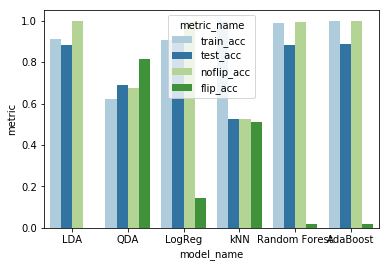

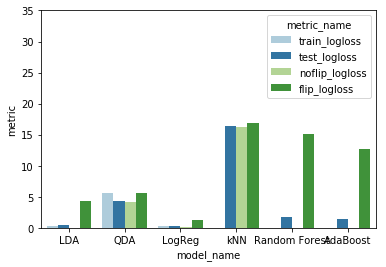

In [18]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev', 'dem_win_prev', 
               'female_pct', 'civilian_veteran_pct', 'foreign_to_native_born_ratio', 'labor_force_unemployed_pct',
               'age18_24_pct', 'bachelors_deg_or_higher_pct', 'age25_34_pct', 'median_household_income'] 
state_hot_encoder = True

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

## Impute 2010 data into all non-redistricted districts in prior years. 

### Dataset since 2004, with demographics imputed, redistrited states not dropped

LDA
60 60
intercept = [-26.39684654]
[('national_poll', 0.19947664272512383), ('margin_signed_minus_prev', 2.2499992724980737), ('dem_win_prev', 10.32283135495446), ('female_pct', 0.3420208173858874), ('civilian_veteran_pct', -0.18513029807358694), ('foreign_to_native_born_ratio', 0.08649804885362178), ('labor_force_unemployed_pct', 0.04751930709555424), ('age18_24_pct', 0.13049888540829607), ('bachelors_deg_or_higher_pct', -0.009747312902512297), ('age25_34_pct', 0.21725516828318536), ('median_household_income', -2.7589382879413683e-06), ('state_AL', -0.5670344531408251), ('state_AR', -1.0548470598672814), ('state_AZ', 1.0436016392989438), ('state_CA', 0.7250441875219704), ('state_CO', 1.150950581491776), ('state_CT', 3.3585929537702093), ('state_DE', 2.9019396316380552), ('state_FL', 0.5762761888759151), ('state_GA', -0.030501735001793727), ('state_HI', 3.5142569036266904), ('state_IA', 0.7678106008590353), ('state_ID', -0.5793631188328774), ('state_IL', 0.35549578211260524), ('state

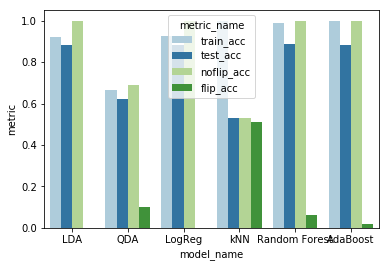

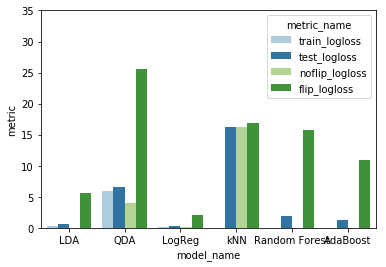

In [19]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev', 'dem_win_prev', 
               'female_pct', 'civilian_veteran_pct', 'foreign_to_native_born_ratio', 'labor_force_unemployed_pct',
               'age18_24_pct', 'bachelors_deg_or_higher_pct', 'age25_34_pct', 'median_household_income']
state_hot_encoder = True

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

### Dataset since 2004, with demographics imputed, redistrited states dropped

LDA
60 60
intercept = [-27.27014498]
[('national_poll', 0.2583055508073777), ('margin_signed_minus_prev', 3.053238242919769), ('dem_win_prev', 13.600916023326143), ('female_pct', 0.3374351446817644), ('civilian_veteran_pct', -0.11448348657920465), ('foreign_to_native_born_ratio', -0.010237274188576414), ('labor_force_unemployed_pct', -0.015189641398146735), ('age18_24_pct', 0.04595547571695041), ('bachelors_deg_or_higher_pct', -0.01222135326061778), ('age25_34_pct', 0.19636534997883795), ('median_household_income', -2.040708703528026e-06), ('state_AL', -0.6167344131925356), ('state_AR', -1.0434846722978643), ('state_AZ', 0.732876727143353), ('state_CA', 0.8550781216979706), ('state_CO', 1.20688249380109), ('state_CT', 3.783791593408949), ('state_DE', 3.443180790334405), ('state_FL', -0.013844550796315021), ('state_GA', 0.23362512073996214), ('state_HI', 3.2417711991419864), ('state_IA', 1.0916162864470074), ('state_ID', -0.4974036568298607), ('state_IL', -0.04910261796865498), ('state_

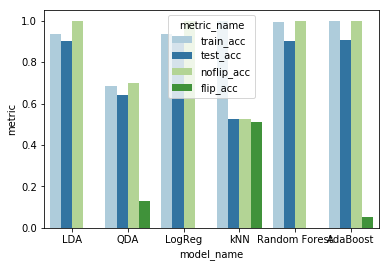

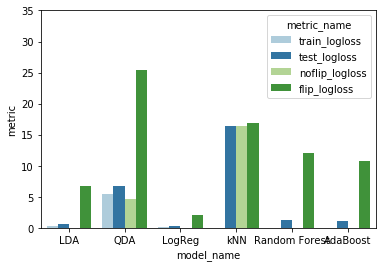

In [20]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018_REDISTRICTDROP.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev', 'dem_win_prev', 
               'female_pct', 'civilian_veteran_pct', 'foreign_to_native_born_ratio', 'labor_force_unemployed_pct',
               'age18_24_pct', 'bachelors_deg_or_higher_pct', 'age25_34_pct', 'median_household_income']
state_hot_encoder = True

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

### Demographics Imputed Back, Redistricted States Imputed, only new districts dropped

LDA
59 59
intercept = [-16.46520034]
[('national_poll', 0.12421938136495494), ('margin_signed_minus_prev', 8.229629856199676), ('female_pct', 0.22910362305745896), ('civilian_veteran_pct', -0.1052460224390187), ('foreign_to_native_born_ratio', 0.8217859824799261), ('labor_force_unemployed_pct', 0.007028928505002523), ('age18_24_pct', 0.11146090068713002), ('bachelors_deg_or_higher_pct', -0.013989590978214101), ('age25_34_pct', 0.19633491304805323), ('median_household_income', -4.974461653160769e-06), ('state_AL', 0.9148584955630517), ('state_AR', 0.23216347018638667), ('state_AZ', 2.0058473124778238), ('state_CA', 1.9074904062816742), ('state_CO', 2.0678182669531178), ('state_CT', 5.021138952446085), ('state_DE', 3.674013103738412), ('state_FL', 1.104524781169915), ('state_GA', 1.3989117922611707), ('state_HI', 5.172315544022356), ('state_IA', 1.9933148001115477), ('state_ID', -0.008683525764254556), ('state_IL', 1.2695247335071782), ('state_IN', 1.032082394269179), ('state_KS', 0.7979

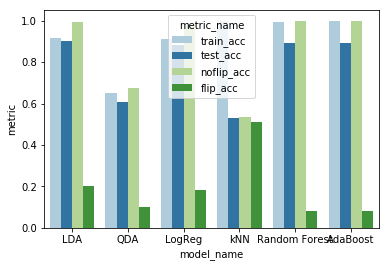

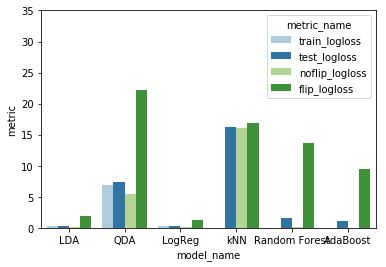

In [21]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_DISTRICTMIXED_2004_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev', #'dem_win_prev', 
               'female_pct', 'civilian_veteran_pct', 'foreign_to_native_born_ratio', 'labor_force_unemployed_pct',
               'age18_24_pct', 'bachelors_deg_or_higher_pct', 'age25_34_pct', 'median_household_income']
state_hot_encoder = True

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

# Model Graveyard

Here lie all the models that were way too complicated and overfit because we literally threw every predictor in there just to see if it was working 

### Full dataset, no demographics, not dropping any data. 

LDA
12 12
intercept = [1.51659156]
[('national_poll', 0.12596408594822361), ('national_poll_prev', -0.003915287637835136), ('national_poll_delta_subtract', 0.0697807067197695), ('national_poll_delta_divide', 0.019684247927879414), ('dem_win_margin_prev', 0.24461313994817122), ('rep_win_margin_prev', -5.226111474656156), ('margin_signed_minus_prev', 1.412648673332996), ('margin_signed_divide_prev', -4.1268637365191044e-10), ('margin_unsigned_minus_prev', 0.4355582733979102), ('margin_unsigned_divide_prev', 1.6930833639356982e-10), ('dem_win_prev', 4.923238559252514), ('rep_win_prev', -4.923238559252517)]
QDA
doesnt have any coefficients
LogReg
12 12
intercept = [-3.47906445e-18]
[('national_poll', 2.522043147904857e-17), ('national_poll_prev', 1.2311790161345366e-17), ('national_poll_delta_subtract', 1.2908641317703353e-17), ('national_poll_delta_divide', 5.734964333551661e-18), ('dem_win_margin_prev', 1.2860198684462452e-17), ('rep_win_margin_prev', -1.666991051471099e-17), ('margin_si

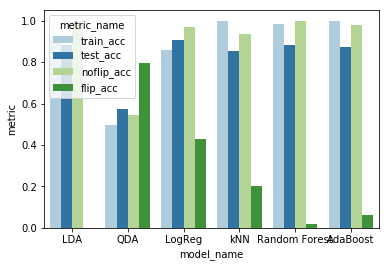

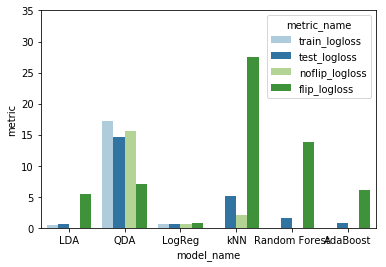

In [22]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018.p'
cols_to_use = ['national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev'] # all of them
state_hot_encoder = False


fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

### Full dataset, no demographics, dropping redistricted states

LDA
12 12
intercept = [2.02817103]
[('national_poll', 0.16715616267066508), ('national_poll_prev', -0.0006019479069554086), ('national_poll_delta_subtract', 0.09237643225718897), ('national_poll_delta_divide', -0.018232512714201017), ('dem_win_margin_prev', 0.03141430209859689), ('rep_win_margin_prev', -6.329285923601034), ('margin_signed_minus_prev', 1.6419292745715), ('margin_signed_divide_prev', -5.02431800885479e-10), ('margin_unsigned_minus_prev', 0.21323261051811587), ('margin_unsigned_divide_prev', 2.019192503808164e-10), ('dem_win_prev', 6.608769508400643), ('rep_win_prev', -6.60876950840064)]
QDA
doesnt have any coefficients
LogReg
12 12
intercept = [-1.03873015e-15]
[('national_poll', 9.844432255150251e-15), ('national_poll_prev', 4.268239227615791e-15), ('national_poll_delta_subtract', 5.5761930275345926e-15), ('national_poll_delta_divide', 1.5675440554887245e-15), ('dem_win_margin_prev', 4.223489803841251e-15), ('rep_win_margin_prev', -5.38081408397584e-15), ('margin_signed

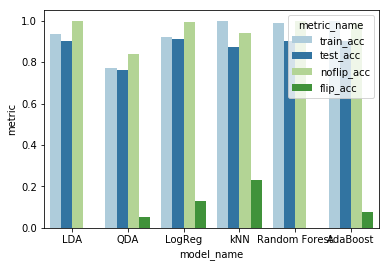

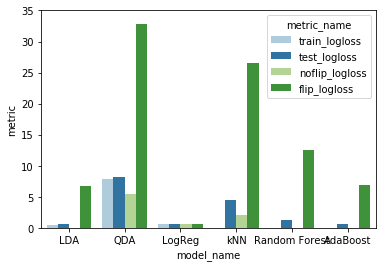

In [23]:
# specify columns to use and the file you want to read in 
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p'
state_hot_encoder = False # some states get dropped so this leads to problems
cols_to_use = ['national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev'] # all of them

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

### Dataset since 2010, with demographics, nothing dropped

LDA
79 79
intercept = [-86.64835639]
[('national_poll', 0.9261510966121032), ('national_poll_prev', 0.228860362328699), ('national_poll_delta_subtract', -0.005349147197503115), ('national_poll_delta_divide', -0.4749509626880126), ('dem_win_margin_prev', 0.8342375980914569), ('rep_win_margin_prev', -1.0023657538454798), ('margin_signed_minus_prev', 0.47300260509275993), ('margin_signed_divide_prev', -2.476882201334006e-10), ('margin_unsigned_minus_prev', 1.2173785444681138), ('margin_unsigned_divide_prev', 4.169427686711579e-12), ('dem_win_prev', 4.401265542229053), ('rep_win_prev', -4.401265542229152), ('female_pct', 1.0868518261983624), ('age18_24_pct', 0.3063114731803732), ('age25_34_pct', 0.12549854623089202), ('median_age', 0.025155139775971586), ('unmarried_partner_pct', 0.891848927184915), ('male_living_alone_pct', 0.3966047667459094), ('bachelors_deg_or_higher_pct', -0.007294738507203054), ('civilian_veteran_pct', -0.06198646126982893), ('live_same_house_past_year_pct', 0.051369

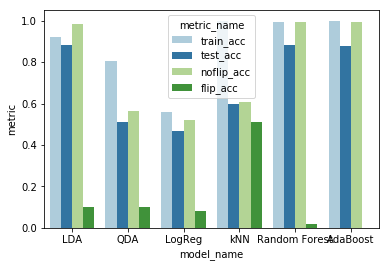

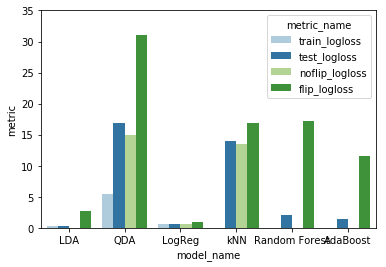

In [15]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
cols_to_use = ['national_poll', 'national_poll_prev', 'national_poll_delta_subtract', 
               'national_poll_delta_divide', 'dem_win_margin_prev', 'rep_win_margin_prev',
               'margin_signed_minus_prev', 'margin_signed_divide_prev', 
               'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev', 
               'dem_win_prev', 'rep_win_prev', 'female_pct', 'age18_24_pct', 
               'age25_34_pct', 'median_age', 'unmarried_partner_pct', 
               'male_living_alone_pct', 'bachelors_deg_or_higher_pct', 
               'civilian_veteran_pct', #'past_year_births_to_unmarried_women_pct', # has a string in it
               'live_same_house_past_year_pct', 
               'foreign_born_proportion_from_LatinAmerica', 
               'speak_other_language_at_home_pct', 'labor_force_unemployed_pct', 
               'public_transit_commuter_pct', 'no_health_insurance_pct', 
                'poverty_rate_pct', 'median_household_income', # 'median_housing_value', # has a string in it
                'food_stamp_benefits_pct', 'foreign_to_native_born_ratio' 
              ] # everything

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

### Dataset since 2010, with demographics, dropping redistricted states

LDA
79 79
intercept = [-69.27640069]
[('national_poll', 1.7969653954300773), ('national_poll_prev', 0.5047413445839884), ('national_poll_delta_subtract', 0.033766765563139955), ('national_poll_delta_divide', -1.3696764054023556), ('dem_win_margin_prev', -2.2689445039960203), ('rep_win_margin_prev', -5.743795436670496), ('margin_signed_minus_prev', 0.9039622217811112), ('margin_signed_divide_prev', -4.3044111723166166e-10), ('margin_unsigned_minus_prev', 2.762083935482431), ('margin_unsigned_divide_prev', -1.059686572966432e-11), ('dem_win_prev', 6.520274433827167), ('rep_win_prev', -6.520274433826838), ('female_pct', 1.0816395268504087), ('age18_24_pct', 0.1293603421469052), ('age25_34_pct', 0.031620406456585905), ('median_age', 0.004118704362729713), ('unmarried_partner_pct', 0.5581447700808574), ('male_living_alone_pct', 0.36640708361323177), ('bachelors_deg_or_higher_pct', -0.026422800627083763), ('civilian_veteran_pct', -0.07049302869186921), ('live_same_house_past_year_pct', -0.04

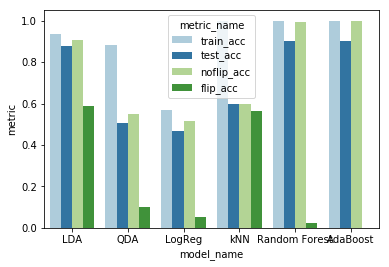

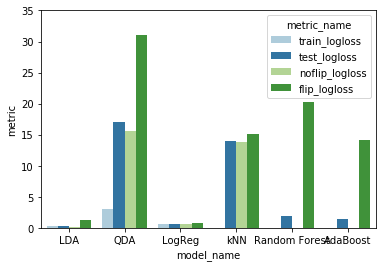

In [16]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p'
cols_to_use = ['national_poll', 'national_poll_prev', 'national_poll_delta_subtract', 
               'national_poll_delta_divide', 'dem_win_margin_prev', 'rep_win_margin_prev',
               'margin_signed_minus_prev', 'margin_signed_divide_prev', 
               'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev', 
               'dem_win_prev', 'rep_win_prev', 'female_pct', 'age18_24_pct', 
               'age25_34_pct', 'median_age', 'unmarried_partner_pct', 
               'male_living_alone_pct', 'bachelors_deg_or_higher_pct', 
               'civilian_veteran_pct', #'past_year_births_to_unmarried_women_pct', # has a string in it
               'live_same_house_past_year_pct', 
               'foreign_born_proportion_from_LatinAmerica', 
               'speak_other_language_at_home_pct', 'labor_force_unemployed_pct', 
               'public_transit_commuter_pct', 'no_health_insurance_pct', 
                'poverty_rate_pct', 'median_household_income', # 'median_housing_value', # has a string in it
                'food_stamp_benefits_pct', 'foreign_to_native_born_ratio' 
              ] # everything
state_hot_encoder = True

fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=state_hot_encoder, upsample=upsample)

# Data Exploration

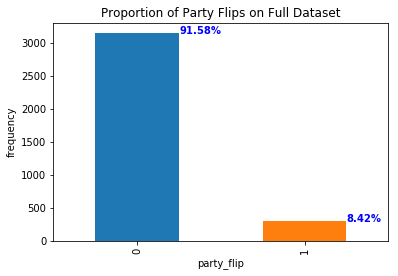

In [3]:
# Plot the proportion of flips in the full dataset

#read in FEC data
full_dataset = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018.p', 'rb'))
full_dataset_redistrict = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p', 'rb'))

#add column to indicate a party flip
full_dataset['party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
full_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
full_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on Full Dataset')

for name, group in (full_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/full_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')

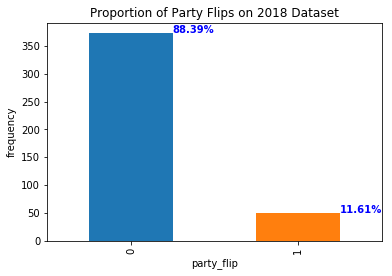

In [4]:
# Plot the proportion of flips in 2018

#add column to indicate a party flip
the_2018_dataset = full_dataset.loc[full_dataset['year']==2018,:]
the_2018_dataset.loc[:,'party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
the_2018_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
the_2018_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on 2018 Dataset')

for name, group in (the_2018_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/the_2018_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')